# Retina Blood Vessels Detection

Main notebook for the project.
List of contents:
1. Description of the problem
2. Classic method
3. Deep learning method
4. Conclusion

# Description of the problem

Having an image of the retina of the eye as an input, we have to detect which of the individual pixels are blood vessels. \
Two approaches were used for this:
1. Classic method
2. Deep learning method

### Notebook's imports

In [2]:
import os
import random
import gc
from glob import glob
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from classifiers.classic import ClassicClassifier
from utils.confusion_matrix import ConfusionMatrix
from notebooks.unet.unet import UNet
from notebooks.utils.accuracy import calculate_accuracy

# Classic method

The classic approach uses filters to detect the edges of objects in the image. Detailed process below:

1. Separation data into RGB channels and extraction of the green channel for processing.
2. Application of a CLAHE filter.
3. Application of erosion and dilation (morphological filters) for each kernel from `kernel_sizes`
4. Application of CLAHE filter.
5. Application of image thresholding.
6. Determination of the mask.
7. Determination of the contours.
8. Re-application of the thresholding.

All functionality is included in the `ClassicClassifier` class. Below you can see the result of using the classifier.

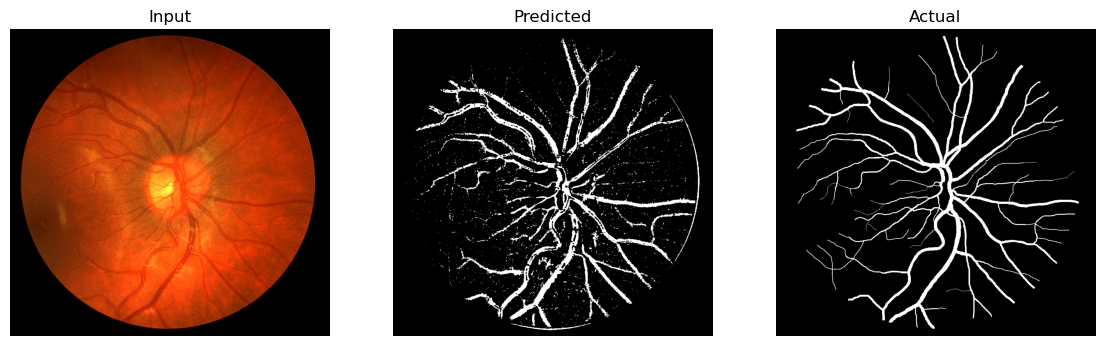

Accuracy:    0.9411724224224224
Recall:      0.6966421245265353
Precision    0.5836274824401897
Specificity: 0.9605716735936903



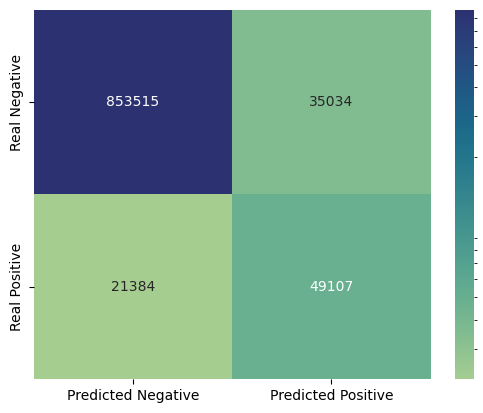

In [11]:
# Create Classifier and predict
cc = ClassicClassifier([(5, 5), (12, 12), (20, 20)], 200)
image = cv2.imread("../data/CHASED/test/images/Image_12R.jpg")
test_image = cv2.imread("../data/CHASED/test/answers/Image_12R_1stHO.png", cv2.IMREAD_GRAYSCALE)
pred_image = cc.predict(image)

# Plot results
fig = plt.figure(figsize=(14, 10))
fig.add_subplot(131)
plt.title("Input")
plt.imshow(image[:, :, ::-1])
plt.axis('off')

fig.add_subplot(132)
plt.title("Predicted")
plt.imshow(pred_image, cmap='gray')
plt.axis('off')

fig.add_subplot(133)
plt.title("Actual")
plt.imshow(test_image, cmap='gray')
plt.axis('off')
plt.show()

# Calculate confusion matrix
classic_cm = ConfusionMatrix(test_image.flatten(), pred_image.flatten())
print(classic_cm)
classic_cm.heatmap()

As you can see, you can easily recognize the contours of the correct image, but there are a lot of distortions and incorrectly classified pixels. This is indicated by Recall and Precision.

# Deep Learning

To use deep learning, we decided to use the UNet network, which is one of the best known when it comes to detecting data from medical images. Below is the structure of the network.

![unet](../readme-images/u-net-architecture.png)

Steps used in training

In [4]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: nn.Module,
               accuracy_fn,
               device: torch.device):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy_fn(y_pred, y)

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")

In [5]:
def valid_step(model, loader, loss_fn, accuracy_fn, device):
    valid_loss, valid_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            valid_loss += loss.item()
            valid_acc += accuracy_fn(y_pred, y)

    valid_loss /= len(loader)
    valid_acc /= len(loader)
    print(f"Valid loss: {valid_loss:.5f} | Valid accuracy: {valid_acc:.2f}")

    return valid_loss

Dataset used to upload data to the model

In [6]:
class ChasedDataset(Dataset):
    def __init__(self, images_path, answers_path):
        self.images_path = images_path
        self.answers_path = answers_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        img = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        img = img / 255.0
        img = np.transpose(img, (2, 0, 1))
        img = torch.from_numpy(img.astype(np.float32))

        ans = cv2.imread(self.answers_path[index], cv2.IMREAD_GRAYSCALE)
        ans = cv2.resize(ans, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
        ans = ans / 255.0
        ans = ans[np.newaxis, ...]
        ans = torch.from_numpy(ans.astype(np.float32))

        return img, ans

    def __len__(self):
        return self.n_samples

Loss function: combination of Dice and Binary Cross Entropy

In [7]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

Constants used in learning

In [9]:
H, W = 512, 512
BATCH_SIZE = 1
EPOCHS = 50
LR = 1e-4
CHECKPOINT = r"../models/unet_checkpoint.pth"
DATA_PATH = r"../data/CHASED"
SEED = 42

Main loop

In [7]:
gc.collect()
torch.cuda.empty_cache()

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_x = sorted(glob(f"{DATA_PATH}/train/images/*"))
train_y = sorted(glob(f"{DATA_PATH}/train/answers/*"))

valid_x = sorted(glob(f"{DATA_PATH}/valid/images/*"))
valid_y = sorted(glob(f"{DATA_PATH}/valid/answers/*"))

print(f"Dataset Size:\nTrain: {len(train_x)} - Validation: {len(valid_x)}")

train_dataset = ChasedDataset(train_x, train_y)
valid_dataset = ChasedDataset(valid_x, valid_y)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

device = torch.device('cuda')
model = UNet(3)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()


best_valid_loss = float("inf")
for epoch in tqdm(range(EPOCHS)):

    train_step(model, train_loader, optimizer, loss_fn, calculate_accuracy, device)
    valid_loss = valid_step(model, valid_loader, loss_fn, calculate_accuracy, device)

    if valid_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {CHECKPOINT}"
        print(data_str)

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), CHECKPOINT)

Dataset Size:
Train: 20 - Validation: 3


  0%|          | 0/50 [00:00<?, ?it/s]


Train loss: 1.29628 | Train accuracy: 0.86
Valid loss: 1.45321 | Valid accuracy: 0.94
Valid loss improved from inf to 1.4532. Saving checkpoint: ../models/unet_checkpoint.pth


  2%|▏         | 1/50 [00:12<10:18, 12.63s/it]


Train loss: 1.08837 | Train accuracy: 0.93


  4%|▍         | 2/50 [00:24<09:44, 12.18s/it]

Valid loss: 1.33962 | Valid accuracy: 0.94
Valid loss improved from 1.4532 to 1.3396. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 1.02148 | Train accuracy: 0.95


  6%|▌         | 3/50 [00:36<09:27, 12.07s/it]

Valid loss: 1.11928 | Valid accuracy: 0.96
Valid loss improved from 1.3396 to 1.1193. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.97902 | Train accuracy: 0.95


  8%|▊         | 4/50 [00:48<09:13, 12.03s/it]

Valid loss: 1.04248 | Valid accuracy: 0.96
Valid loss improved from 1.1193 to 1.0425. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.94862 | Train accuracy: 0.96


 10%|█         | 5/50 [01:00<09:01, 12.04s/it]

Valid loss: 1.01596 | Valid accuracy: 0.96
Valid loss improved from 1.0425 to 1.0160. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.91882 | Train accuracy: 0.96


 12%|█▏        | 6/50 [01:12<08:50, 12.05s/it]

Valid loss: 0.98136 | Valid accuracy: 0.96
Valid loss improved from 1.0160 to 0.9814. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.89349 | Train accuracy: 0.96


 14%|█▍        | 7/50 [01:24<08:34, 11.96s/it]

Valid loss: 0.95993 | Valid accuracy: 0.97
Valid loss improved from 0.9814 to 0.9599. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.87191 | Train accuracy: 0.96


 16%|█▌        | 8/50 [01:36<08:20, 11.92s/it]

Valid loss: 0.94440 | Valid accuracy: 0.97
Valid loss improved from 0.9599 to 0.9444. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.84544 | Train accuracy: 0.97


 18%|█▊        | 9/50 [01:47<08:07, 11.89s/it]

Valid loss: 0.91583 | Valid accuracy: 0.97
Valid loss improved from 0.9444 to 0.9158. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.82154 | Train accuracy: 0.97


 20%|██        | 10/50 [01:59<07:55, 11.88s/it]

Valid loss: 0.89967 | Valid accuracy: 0.96
Valid loss improved from 0.9158 to 0.8997. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.80088 | Train accuracy: 0.97


 22%|██▏       | 11/50 [02:11<07:43, 11.88s/it]

Valid loss: 0.89788 | Valid accuracy: 0.96
Valid loss improved from 0.8997 to 0.8979. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.77966 | Train accuracy: 0.97


 24%|██▍       | 12/50 [02:23<07:31, 11.88s/it]

Valid loss: 0.86544 | Valid accuracy: 0.97
Valid loss improved from 0.8979 to 0.8654. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.75544 | Train accuracy: 0.97


 26%|██▌       | 13/50 [02:35<07:20, 11.92s/it]

Valid loss: 0.85707 | Valid accuracy: 0.97
Valid loss improved from 0.8654 to 0.8571. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.73617 | Train accuracy: 0.97


 28%|██▊       | 14/50 [02:47<07:09, 11.93s/it]

Valid loss: 0.83371 | Valid accuracy: 0.97
Valid loss improved from 0.8571 to 0.8337. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.71464 | Train accuracy: 0.97


 30%|███       | 15/50 [02:59<06:58, 11.97s/it]

Valid loss: 0.81506 | Valid accuracy: 0.97
Valid loss improved from 0.8337 to 0.8151. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.69218 | Train accuracy: 0.98


 32%|███▏      | 16/50 [03:11<06:46, 11.96s/it]

Valid loss: 0.81635 | Valid accuracy: 0.97

Train loss: 0.67212 | Train accuracy: 0.98


 34%|███▍      | 17/50 [03:23<06:34, 11.95s/it]

Valid loss: 0.81789 | Valid accuracy: 0.97

Train loss: 0.65098 | Train accuracy: 0.98


 36%|███▌      | 18/50 [03:35<06:22, 11.94s/it]

Valid loss: 0.78200 | Valid accuracy: 0.97
Valid loss improved from 0.8151 to 0.7820. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.63029 | Train accuracy: 0.98


 38%|███▊      | 19/50 [03:47<06:12, 12.02s/it]

Valid loss: 0.77154 | Valid accuracy: 0.97
Valid loss improved from 0.7820 to 0.7715. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.61278 | Train accuracy: 0.98


 40%|████      | 20/50 [03:59<06:01, 12.04s/it]

Valid loss: 0.76059 | Valid accuracy: 0.97
Valid loss improved from 0.7715 to 0.7606. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.59210 | Train accuracy: 0.98


 42%|████▏     | 21/50 [04:11<05:50, 12.10s/it]

Valid loss: 0.74487 | Valid accuracy: 0.97
Valid loss improved from 0.7606 to 0.7449. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.57308 | Train accuracy: 0.98


 44%|████▍     | 22/50 [04:24<05:40, 12.14s/it]

Valid loss: 0.73225 | Valid accuracy: 0.97
Valid loss improved from 0.7449 to 0.7322. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.55721 | Train accuracy: 0.98


 46%|████▌     | 23/50 [04:36<05:28, 12.18s/it]

Valid loss: 0.71995 | Valid accuracy: 0.97
Valid loss improved from 0.7322 to 0.7200. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.53761 | Train accuracy: 0.98


 48%|████▊     | 24/50 [04:48<05:18, 12.24s/it]

Valid loss: 0.70015 | Valid accuracy: 0.97
Valid loss improved from 0.7200 to 0.7002. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.52117 | Train accuracy: 0.99


 50%|█████     | 25/50 [05:01<05:07, 12.29s/it]

Valid loss: 0.69355 | Valid accuracy: 0.97
Valid loss improved from 0.7002 to 0.6935. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.51062 | Train accuracy: 0.98


 52%|█████▏    | 26/50 [05:13<04:55, 12.30s/it]

Valid loss: 0.66725 | Valid accuracy: 0.97
Valid loss improved from 0.6935 to 0.6672. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.49664 | Train accuracy: 0.98


 54%|█████▍    | 27/50 [05:25<04:41, 12.23s/it]

Valid loss: 0.70364 | Valid accuracy: 0.97

Train loss: 0.47860 | Train accuracy: 0.99


 56%|█████▌    | 28/50 [05:38<04:30, 12.29s/it]

Valid loss: 0.64117 | Valid accuracy: 0.97
Valid loss improved from 0.6672 to 0.6412. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.46275 | Train accuracy: 0.99


 58%|█████▊    | 29/50 [05:50<04:16, 12.23s/it]

Valid loss: 0.64299 | Valid accuracy: 0.97

Train loss: 0.44959 | Train accuracy: 0.99


 60%|██████    | 30/50 [06:02<04:04, 12.21s/it]

Valid loss: 0.65979 | Valid accuracy: 0.97

Train loss: 0.44113 | Train accuracy: 0.99


 62%|██████▏   | 31/50 [06:14<03:52, 12.24s/it]

Valid loss: 0.62452 | Valid accuracy: 0.97
Valid loss improved from 0.6412 to 0.6245. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.42444 | Train accuracy: 0.99


 64%|██████▍   | 32/50 [06:27<03:41, 12.30s/it]

Valid loss: 0.61396 | Valid accuracy: 0.97
Valid loss improved from 0.6245 to 0.6140. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.40536 | Train accuracy: 0.99


 66%|██████▌   | 33/50 [06:39<03:29, 12.30s/it]

Valid loss: 0.61037 | Valid accuracy: 0.97
Valid loss improved from 0.6140 to 0.6104. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.39030 | Train accuracy: 0.99


 68%|██████▊   | 34/50 [06:51<03:16, 12.26s/it]

Valid loss: 0.61499 | Valid accuracy: 0.97

Train loss: 0.37735 | Train accuracy: 0.99


 70%|███████   | 35/50 [07:03<03:04, 12.29s/it]

Valid loss: 0.60149 | Valid accuracy: 0.97
Valid loss improved from 0.6104 to 0.6015. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.36872 | Train accuracy: 0.99


 72%|███████▏  | 36/50 [07:16<02:52, 12.30s/it]

Valid loss: 0.59143 | Valid accuracy: 0.97
Valid loss improved from 0.6015 to 0.5914. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.36179 | Train accuracy: 0.99


 74%|███████▍  | 37/50 [07:28<02:40, 12.32s/it]

Valid loss: 0.58024 | Valid accuracy: 0.97
Valid loss improved from 0.5914 to 0.5802. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.35234 | Train accuracy: 0.99


 76%|███████▌  | 38/50 [07:41<02:28, 12.40s/it]

Valid loss: 0.56027 | Valid accuracy: 0.97
Valid loss improved from 0.5802 to 0.5603. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.34319 | Train accuracy: 0.99


 78%|███████▊  | 39/50 [07:52<02:13, 12.17s/it]

Valid loss: 0.55667 | Valid accuracy: 0.97
Valid loss improved from 0.5603 to 0.5567. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.33009 | Train accuracy: 0.99


 80%|████████  | 40/50 [08:04<02:00, 12.08s/it]

Valid loss: 0.54439 | Valid accuracy: 0.97
Valid loss improved from 0.5567 to 0.5444. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.31900 | Train accuracy: 0.99


 82%|████████▏ | 41/50 [08:16<01:47, 11.95s/it]

Valid loss: 0.54866 | Valid accuracy: 0.97

Train loss: 0.30965 | Train accuracy: 0.99


 84%|████████▍ | 42/50 [08:28<01:36, 12.05s/it]

Valid loss: 0.53807 | Valid accuracy: 0.97
Valid loss improved from 0.5444 to 0.5381. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.30419 | Train accuracy: 0.99


 86%|████████▌ | 43/50 [08:40<01:24, 12.10s/it]

Valid loss: 0.53722 | Valid accuracy: 0.97
Valid loss improved from 0.5381 to 0.5372. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.29808 | Train accuracy: 0.99


 88%|████████▊ | 44/50 [08:52<01:12, 12.03s/it]

Valid loss: 0.53137 | Valid accuracy: 0.97
Valid loss improved from 0.5372 to 0.5314. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.29574 | Train accuracy: 0.99


 90%|█████████ | 45/50 [09:04<00:59, 11.94s/it]

Valid loss: 0.54690 | Valid accuracy: 0.97

Train loss: 0.29050 | Train accuracy: 0.99


 92%|█████████▏| 46/50 [09:16<00:47, 11.87s/it]

Valid loss: 0.51942 | Valid accuracy: 0.97
Valid loss improved from 0.5314 to 0.5194. Saving checkpoint: ../models/unet_checkpoint.pth

Train loss: 0.27547 | Train accuracy: 0.99


 94%|█████████▍| 47/50 [09:27<00:35, 11.77s/it]

Valid loss: 0.52223 | Valid accuracy: 0.97

Train loss: 0.26182 | Train accuracy: 0.99


 96%|█████████▌| 48/50 [09:39<00:23, 11.73s/it]

Valid loss: 0.52334 | Valid accuracy: 0.97

Train loss: 0.25366 | Train accuracy: 0.99


 98%|█████████▊| 49/50 [09:50<00:11, 11.67s/it]

Valid loss: 0.52747 | Valid accuracy: 0.97

Train loss: 0.24628 | Train accuracy: 0.99


100%|██████████| 50/50 [10:02<00:00, 12.05s/it]

Valid loss: 0.48520 | Valid accuracy: 0.97
Valid loss improved from 0.5194 to 0.4852. Saving checkpoint: ../models/unet_checkpoint.pth


Predictions made using trained neural network

In [10]:
def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

test_x = sorted(glob(f"{DATA_PATH}/test/images/*"))
test_y = sorted(glob(f"{DATA_PATH}/test/answers/*"))

device = 'cuda'

model_test = UNet(3)
model_test.load_state_dict(torch.load(CHECKPOINT, map_location=device))
# model_test.to(device)
model_test.eval()

for i, (x, y) in enumerate(zip(test_x, test_y)):
    name = x.split("\\")[-1].split(".")[0]

    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.resize(image, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
    img = image / 255.0
    img = np.transpose(img, (2, 0, 1))
    img = img[np.newaxis, ...]
    img = torch.from_numpy(img.astype(np.float32))
    # img.to(device)

    answer = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    answer = cv2.resize(answer, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
    ans = answer / 255.0
    ans = ans[np.newaxis, ...]
    ans = torch.from_numpy(ans.astype(np.float32))
    # ans.to(device)

    with torch.no_grad():
        pred_y = model_test(img)

        pred_y = pred_y[0].cpu().numpy()
        pred_y = np.squeeze(pred_y, axis=0)
        pred_y = pred_y > 0.5
        pred_y = np.array(pred_y, dtype=np.uint8)

    # calculate confusion matrix
    y_true = ans.cpu().detach().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    y_pred = pred_y > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    cm = ConfusionMatrix(y_true, y_pred)

    # save image
    answer = mask_parse(answer)
    pred_y = mask_parse(pred_y)
    line = np.ones((512, 10, 3)) * 128
    cat_images = np.concatenate(
        [image, line, answer, line, pred_y*255], axis=1
    )

    print("-"*30)
    print(f"{i+1}.\t{name}")
    print(cm)

    cv2.imwrite(f"{DATA_PATH}/{name}.png", cat_images)

------------------------------
1.	Image_12R
Accuracy:    0.9690933227539062
Recall:      0.8013098184818482
Precision    0.7852739033757833
Specificity: 0.9824965396783548

------------------------------
2.	Image_13L
Accuracy:    0.9592208862304688
Recall:      0.40059494298463066
Precision    0.8639401229617749
Specificity: 0.9958619231894897

------------------------------
3.	Image_13R
Accuracy:    0.9580841064453125
Recall:      0.40773827488380515
Precision    0.851721094439541
Specificity: 0.995211277929122

------------------------------
4.	Image_14L
Accuracy:    0.9708290100097656
Recall:      0.7001878660625483
Precision    0.8508695360236352
Specificity: 0.9908992566975079

------------------------------
5.	Image_14R
Accuracy:    0.9732017517089844
Recall:      0.6836787902489897
Precision    0.8284495695442698
Specificity: 0.9911994230192624



# Conclusions

1. The neural network is better at classifying individual pixels as blood vessels. This is indicated by higher Recall and Precision values, but also Accuracy and Specificity.
2. Although the classical approach gives worse results, its gives results faster and there is no learning process, which can be critical in some applications.

The trained model is used in the web application attached to the project. For more information, check out the README of the project.